## GANs Mini-Project (Week 5 Peer-Graded Assignment)

In [78]:
# Importing required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## PROBLEM DESCRIPTION

This mini-project is part of a Kaggle competition, where the main goal is to build a generative adversarial network (GAN) model that generates 7,000 to 10,000 Monet-style images. More project details and the dataset can be found in the following link to Kaggle.

Kaggle source: https://www.kaggle.com/competitions/gan-getting-started/overview

Contents for this project can be accessed in the following Github Repository:

Github Repository Link: https://github.com/IsraelsLibrary/DTSA_5511_GANs_Kaggle_MiniProject

In [79]:
# Defining the directories for the image locations
monet_jpegs = "data/monet_jpg/"
photos_jpegs = "data/photo_jpg"
monet_tfrec = "data/monet_tfrec"
photos_tfrec = "data/photo_tfrec"

In [80]:
# Reading in the Monet and test JPEG images
monet_list = os.listdir(monet_jpegs)
monet_images = [file for file in monet_list if file.lower().endswith('.jpg')]

photo_list = os.listdir(photos_jpegs)
photo_images = [file for file in photo_list if file.lower().endswith('.jpg')]

In [81]:
# Convert the training and test images into multidimensional arrays
def images_to_arrays(image_paths):
    return [np.array(Image.open(path).convert('RGB')) for path in image_paths]

# Assuming tif_images and test_images are your lists of image filenames
monet_arrays = images_to_arrays([os.path.join(monet_jpegs, image) for image in monet_images])

photo_arrays = images_to_arrays([os.path.join(photos_jpegs, image) for image in photo_images])

print(len(monet_arrays))
print(len(photo_arrays))

300
7038


## EXPLORATORY DATA ANALYSIS

For the first part of exploratory data analysis, I retrieve the size of each image collection as well as the dimensions for each image in the given collections. Upon further investigation, all of the images in each collection have the same size, which is (256, 256, 3). In terms of the number of images, we are working with 300 Monet jpeg images to train with, and will prepare the GAN model as we run tests with it against the given test dataset, which contains 7,038 jpeg images. The following bar graph displays the proportion of training and test images that are involved with this project. In addition to the bar graph, there is also the inclusion of two histograms that present the frequency distributions of image values (each histogram to represent each image collection). The histograms reveal that there is a wide range of image values present within the input datasets (not only that, but the distribution is significantly different between the Monet images and test images). This information will be helpful to know as I move forward with setting up the GAN model architecture. I also included a helper function to clean the data, in case if there are any NULL image values or corrupted images within the datasets.

In [82]:
# Helper function for cleaning the datasets
def clean_data(data):
    cleaned = [ele for ele in data if not np.isnan(ele).any()]
    return cleaned
            

In [83]:
# Cleaning the data
# Confirm that all multidimensional arrays have the same dimension
# This is for both Monet images and the 'test' photo images

clean_data(monet_arrays)
clean_data(photo_arrays)

for array in monet_arrays:
    if array.shape!=(256, 256, 3):
        print(f'Different dimensions of {array.shape} for array {array}')
        
        
        
for array in photo_arrays:
    if array.shape!=(256, 256, 3):
        print(f'Different dimensions of {array.shape} for array {array}')        

In [7]:
print(f"Dimensions for each Monet image: {monet_arrays[0].shape}")
print(f"Dimensions for each 'test' photo image: {photo_arrays[0].shape}")



Dimensions for each Monet image: (256, 256, 3)
Dimensions for each 'test' photo image: (256, 256, 3)


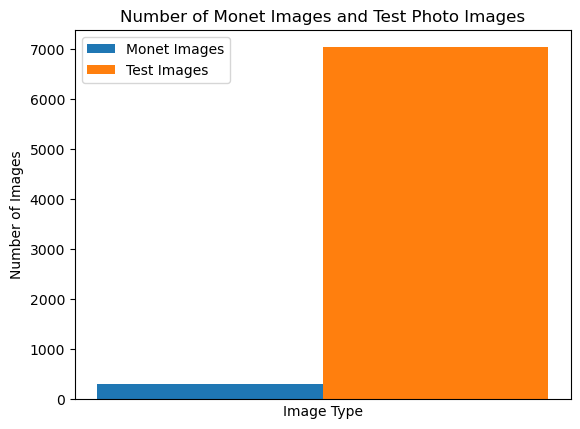

In [8]:
# Create a group bar plot to show the number of Monet images and test images
monet_count = len(monet_arrays)
photo_count = len(photo_arrays)


bar_width = 0.22
index = np.arange(1)

plt.bar(index, [monet_count], bar_width, label='Monet Images')
plt.bar(index + bar_width, [photo_count], bar_width, label='Test Images')



plt.xlabel('Image Type')
plt.ylabel('Number of Images')
plt.title('Number of Monet Images and Test Photo Images')
plt.xticks([])
plt.legend()

plt.show()

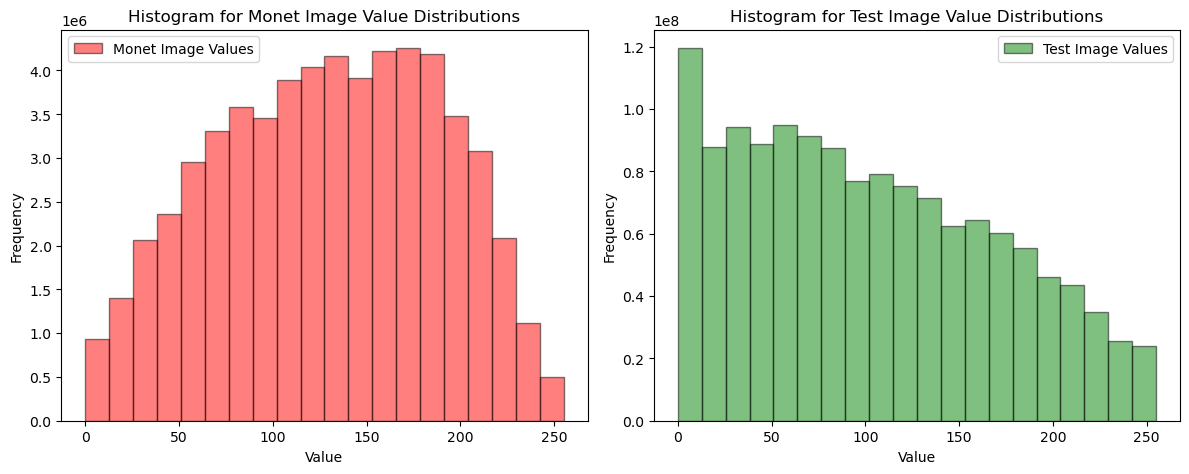

In [9]:
# Histograms to Display Distribution of Pixel Values for each image
# in a given list. One histogram per image collection

# Flatten the 2D arrays to 1D arrays
flattened_monet = np.concatenate([arr.flatten() for arr in monet_arrays])
flattened_photo = np.concatenate([arr.flatten() for arr in photo_arrays])


# Setting up subplots for each list
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plotting histograms for each list
axes[0].hist(flattened_monet, bins=20, alpha=0.5, label='Monet Image Values', color='red', edgecolor='black')
axes[1].hist(flattened_photo, bins=20, alpha=0.5, label='Test Image Values', color='green', edgecolor='black')

axes[0].set_title("Histogram for Monet Image Value Distributions")
axes[1].set_title("Histogram for Test Image Value Distributions")

for axis in axes:
    axis.set_xlabel('Value')
    axis.set_ylabel('Frequency')
    axis.legend()

# Generate the plot
plt.tight_layout()
plt.show()


## THE GANS MODEL AND ARCHITECTURE

For the setup of the model, I developed a class representation of the GAN model for further training purposes. This architecture includes the generator and discriminator as internal functionality, and the generator includes the following components: an input layer that takes the form on the latent dimentions, a series of Dense layers for augmenting the data, a series of Batch Normalization layers and  ELU (Exponential Linear Unit) layers to handle overfitting and apply stability during training, and a reshaping layer to have the generator output have the same dimensions as the input images. In regards to the discriminator, these components form its instrastucture: a flattened layer, a series of leaky ReLU layers, and a series of Dense layers.   This is the initial architecture that I have in place before I make further optimizations. More details on the optimization process and model changes can be found in the next section.

In [11]:
# Readingin in libraries for the GAN model architecture setup
import keras
from keras import layers
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers.legacy import Adam
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input

In [12]:
# Preprocessing the training data
train_data = np.array(monet_arrays)
X_train = train_data
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
print(X_train[0].shape)

(256, 256, 3)


In [13]:
# Preprocessing the test data
test_data = np.array(photo_arrays)

# Rescale pixel values to the range [0, 255]
test_data_rescaled = [(img + 1) * 127.5 for img in test_data]

# Convert images to PIL Image format
test_data_pil = [Image.fromarray((img * 255).astype(np.uint8)) for img in test_data_rescaled]

# Optionally, resize images to a specific size
target_size = (256, 256)
test_data_pil_resized = [img.resize(target_size, Image.ANTIALIAS) for img in test_data_pil]

# Convert PIL Images back to numpy arrays
test_data_processed = [np.array(img) for img in test_data_pil_resized]


/var/folders/k1/f3l1yym17tl9cvqg5972snr00000gn/T/ipykernel_44551/2856631142.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  test_data_pil_resized = [img.resize(target_size, Image.ANTIALIAS) for img in test_data_pil]


In [14]:
# GAN model
class GAN(keras.Model):
    def __init__(self, latent_dim, img_shape, alpha=0.2, dropout=0.5, learning_rate=0.001):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.dropout = dropout
        self.alpha = alpha
        self.img_shape = img_shape
        self.generator_model = None
        self.discriminator_model = None
        self.learning_rate = learning_rate
        self.model = Sequential()
        self.d_loss_arr = []
        self.g_loss_arr = []
        
    def convert_images(test_images):
        noise = np.random.normal(0, 1, (test_images.shape[0], latent_dim))
        synthetic_images = self.generator_model.predict(noise)
        return synthetic_images
        
    def generator(self):
        self.generator_model = Sequential(
            [
                keras.Input(shape=(latent_dim)),
                layers.Dense(256, input_dim=self.latent_dim),
                layers.ELU(alpha=self.alpha),
                layers.BatchNormalization(),
                
                layers.Dense(512),
                layers.ELU(alpha=self.alpha),
                layers.BatchNormalization(),
                
                layers.Dense(1024),
                layers.ELU(alpha=self.alpha),
                layers.BatchNormalization(),

                
                layers.ELU(alpha=self.alpha),
                layers.BatchNormalization(),
                
                layers.Dense(np.prod(self.img_shape), activation="tanh"),
                layers.Reshape(self.img_shape),
            ],
            name="generator"
        )
    
    
    def discriminator(self):

        self.discriminator_model = Sequential(
            [
                layers.Flatten(input_shape=self.img_shape),
                layers.Dense(1024),
                layers.LeakyReLU(alpha=self.alpha),
                
                layers.Dense(512),
                layers.LeakyReLU(alpha=self.alpha),
        
                layers.Dense(256),
                layers.LeakyReLU(alpha=self.alpha),
                
                layers.Dense(1, activation="sigmoid"),
            ],
            name="discriminator"
        )
        
        self.discriminator_model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.001, beta_1=0.5), metrics=['accuracy'])


    def buildGAN(self):
        self.discriminator_model.trainable = False
        self.model.add(self.generator_model)
        self.model.add(self.discriminator_model)
        self.model.compile(loss="binary_crossentropy",
                           optimizer=Adam(learning_rate=self.learning_rate, beta_1=0.5))
        

    def trainGAN(self, data, epochs, batch_size):
        for epoch in range(epochs):
            d_total_loss = 0
            g_total_loss = 0
            
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_images = data[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            true_labels = np.ones((batch_size, 1))
            synthetic_labels = np.zeros((batch_size, 1))
            
            #input_data = np.concatenate([noise, true_labels], axis=1)
            
            print(noise.shape)
            generated_images = self.generator_model.predict(noise)
                
            d_real_loss = self.discriminator_model.train_on_batch(real_images, true_labels)
            d_fake_loss = self.discriminator_model.train_on_batch(generated_images, synthetic_labels)
            d_total_loss += 0.5 * np.add(d_real_loss, d_fake_loss)
            self.d_loss_arr.append(d_total_loss[0])
            self.g_loss_arr.append(g_total_loss)

                
            # Training the generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            generator_labels = np.ones((batch_size, 1))
            g_total_loss += self.model.train_on_batch(noise, generator_labels)
                
            # Print progress and save generated images at intervals
            if epochs <= 100:
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}, Discriminator Loss: {d_total_loss[0]}, Generator Loss: {g_total_loss}")
            else:
                if epoch % 100 == 0:
                    print(f"Epoch {epoch}, Discriminator Loss: {d_total_loss[0]}, Generator Loss: {g_total_loss}")
    
    
    
    
    
    

In [15]:
# Set up the hyperparameters
latent_dim = 100
#img_shape = (256, 256, 3)
img_shape = X_train[0].shape


# Training the GAN model
epochs = 100
batch_size = 16

gan_model0 = GAN(latent_dim=latent_dim, img_shape=img_shape)
gan_model0.generator()
gan_model0.discriminator()
gan_model0.buildGAN()
gan_model0.trainGAN(X_train, epochs, batch_size)

/Users/israeljohnson/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(16, 100)
1/1 [==============================] - 0s 282ms/step
Epoch 0, Discriminator Loss: 0.8326811194419861, Generator Loss: 0.6115262508392334
(16, 100)
1/1 [==============================] - 0s 101ms/step
(16, 100)
1/1 [==============================] - 0s 72ms/step
(16, 100)
1/1 [==============================] - 0s 62ms/step
(16, 100)
1/1 [==============================] - 0s 134ms/step
(16, 100)
1/1 [==============================] - 0s 61ms/step
(16, 100)
1/1 [==============================] - 0s 67ms/step
(16, 100)
1/1 [==============================] - 0s 85ms/step
(16, 100)
1/1 [==============================] - 0s 62ms/step
(16, 100)
1/1 [==============================] - 0s 63ms/step
(16, 100)
1/1 [==============================] - 0s 236ms/step
Epoch 10, Discriminator Loss: 15.456934928894043, Generator Loss: 228.24534606933594
(16, 100)
1/1 [==============================] - 0s 79ms/step
(16, 100)
1/1 [==============================] - 0s 67ms/step
(16, 100)
1/1 [======

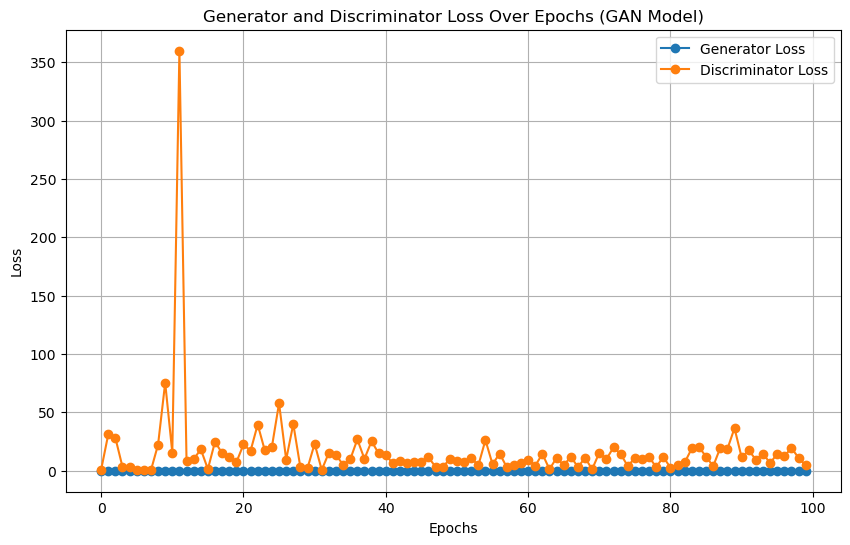

In [16]:
# Plotting the generator and discriminator loss metrics
plt.figure(figsize=(10, 6))
g_loss = list(gan_model0.g_loss_arr)
d_loss = list(gan_model0.d_loss_arr)
epoch_list = range(epochs)
plt.plot(epoch_list, g_loss, label='Generator Loss', marker='o')
plt.plot(epoch_list, d_loss, label='Discriminator Loss', marker='o')

plt.title('Generator and Discriminator Loss Over Epochs (GAN Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## UPDATING AND TRAINING THE GANS MODEL (OPTIMIZATION AND TUNING HYPERPARAMETERS)

According the readouts from the loss values above, the discriminator and generator values fluctuate and end up being fairly high. On the first epoch, they both start closer to zero. However, as the number of epochs increase, the discriminator values become more inconsistent and sporadic (same case with the generator). Overall, it seems that the generator is struggling to generate synthetic images that are similar to the real ones (which explains why the discriminator seems to perform well during certain epochs).

As a result, I realized that I needed to incorporate convolutions for the generator and discriminator, which would help with image processing and augmentation purposes. I decided to learn from the CycleGAN tutorial that is linked to the Kaggle competition. I followed the tutorial in order to restructure my GAN model. I followed a similar format to what was taught in the tutorial, but I also main some key changes that are different. The key differences included the following: <br>

1.) The generator and discriminator components are set up differently. Unlike the components presented in the tutorial, the generator and discriminator components here do not depend on additional upsampling and downsampling methods (these operations are directly incorporated in the componenets and derives from the 'Keras' library). <br>
2.) For the included optimizers, I added a learning rate with a value of 0.0001 to provide stability for the model during training procedures. <br>
3.) As an additional change, I decided to switch from the the JPEG images and use the TFREC version of the images instead.<br>

The updated GAN model seemed to perform much better for the second training process, and I decided to stay with the model for the final result. More details on the revised model architecture and training process are shown below.

In [17]:
# Installing more required libraries
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [18]:
# Reading in further Python libraries for further model setup and training purposes.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

/Users/israeljohnson/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [19]:
MONET_FILES = tf.io.gfile.glob(str('data'+ '/monet_tfrec/*.tfrec'))
PHOTO_FILES = tf.io.gfile.glob(str('data'+ '/photo_tfrec/*.tfrec'))

# Showing the number of Monet and Test images from the TFREC collections
print('Monet TFRecord Files:', len(MONET_FILES))
print('Photo TFRecord Files:', len(PHOTO_FILES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [20]:
# Establishing helper functions to read in the TFREC images and load the datasets.

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [21]:
# Establishing helper functions to read in the TFREC images and load the datasets.
AUTOTUNE = tf.data.experimental.AUTOTUNE
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [22]:
monet_dataset = load_dataset(MONET_FILES, labeled=True).batch(1)
photo_dataset = load_dataset(PHOTO_FILES, labeled=True).batch(1)

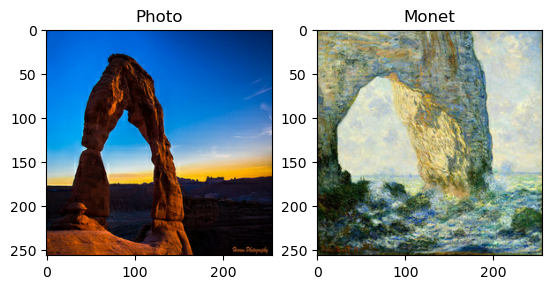

In [23]:
# Displaying sample images from the different datasets
example_monet = next(iter(monet_dataset))
example_photo = next(iter(photo_dataset))


plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [24]:
# The restructured generator for the updated GAN model
def generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
    ]

    up_stack = [
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [25]:
# The restructured discriminator for the updated GAN model
def discriminator():
    inputs = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(1, 4, strides=1, padding='valid')(x) 

    return keras.Model(inputs=inputs, outputs=x)

In [26]:
# Setting up the training process for the new GAN model
try:
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [27]:
# Creating generators and discriminators for the Monet images and Test images, respectively.
with strategy.scope():
    monet_generator = generator()
    photo_generator = generator()
    monet_discriminator = discriminator()
    photo_discriminator = discriminator()

In [29]:
# Setting up the new GAN model
class GAN(keras.Model):
    def __init__(self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=10,):
        super(GAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.d_loss_arr = []
        self.g_loss_arr = []
        
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(GAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Using discriminator to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        self.g_loss_arr.append(total_monet_gen_loss + total_photo_gen_loss)
        self.d_loss_arr.append(monet_disc_loss + photo_disc_loss)
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [30]:
# Calculating the total discriminator loss
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [31]:
# Computing the generator loss
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [32]:
# Computing the cycle consistency loss
with strategy.scope():
    def calc_gan_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [33]:
# Computing the identity loss of the GAN model
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [34]:
# Setting up Adam optimizers for the generators and discriminators, with the added learning rate
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, lr=0.0001)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, lr=0.0001)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, lr=0.0001)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, lr=0.0001)

In [35]:
# Instantiating and compiling the GAN model
with strategy.scope():
    gan_model = GAN(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_gan_loss,
        identity_loss_fn = identity_loss
    )

In [36]:
# Training the GAN model
history = gan_model.fit(tf.data.Dataset.zip((monet_dataset, photo_dataset)), epochs=10)

Epoch 1/10
300/300 [==============================] - 1226s 4s/step - monet_gen_loss: 5.4727 - photo_gen_loss: 5.5193 - monet_disc_loss: 0.6395 - photo_disc_loss: 0.6295
Epoch 2/10
300/300 [==============================] - 1183s 4s/step - monet_gen_loss: 4.0500 - photo_gen_loss: 3.9548 - monet_disc_loss: 0.6511 - photo_disc_loss: 0.6391
Epoch 3/10
300/300 [==============================] - 430s 1s/step - monet_gen_loss: 3.7803 - photo_gen_loss: 3.7860 - monet_disc_loss: 0.6371 - photo_disc_loss: 0.5708
Epoch 4/10
300/300 [==============================] - 348s 1s/step - monet_gen_loss: 3.4509 - photo_gen_loss: 3.4310 - monet_disc_loss: 0.6170 - photo_disc_loss: 0.6340
Epoch 5/10
300/300 [==============================] - 350s 1s/step - monet_gen_loss: 3.2897 - photo_gen_loss: 3.3359 - monet_disc_loss: 0.6314 - photo_disc_loss: 0.6085
Epoch 6/10
300/300 [==============================] - 359s 1s/step - monet_gen_loss: 3.1737 - photo_gen_loss: 3.3118 - monet_disc_loss: 0.6033 - photo_di

## APPLYING TEST DATA TO THE GANS MODEL
As a result of the training process, the discriminator and generator loss metrics appear to be much more consistent. The discriminator loss values appear to stay low, which indicate that it is effective in distinguishing real samples from generated samples. 'More details are given in the Evaluation Metrics and Results' section. During testing and according to the below results, the generated images appear to be quite similar to the real images, indicating success.

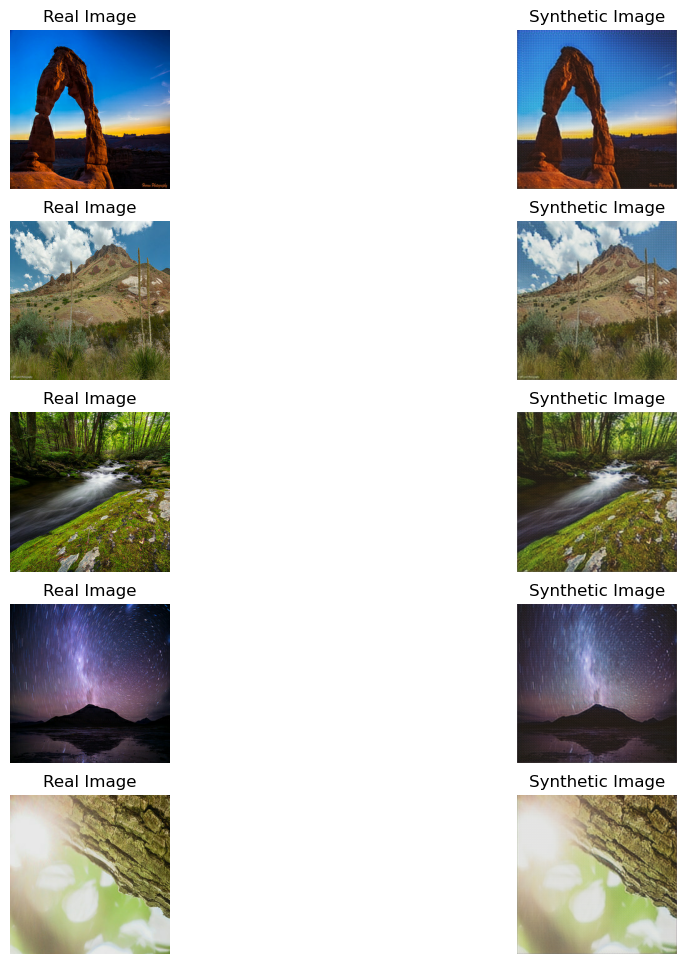

In [71]:
predictions = []
real_images = []
fig, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    predictions.append(prediction)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Real Image")
    ax[i, 1].set_title("Synthetic Image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## EVALUATION METRICS AND RESULTS

The loss metrics in the plot below present an interesting behavior of the generator and discriminator components. The generator loss is high, indicating the the generators are struggling to deceive the discriminator with the generated images. However, both loss metrics appear to stabilize, which means that there is a well-defined balance between the performances of the generator and discriminator components. Overall, the updated GAN model is much more effective, and with further hyperparameter tuning, the GAN model can achieve an even greater performance.

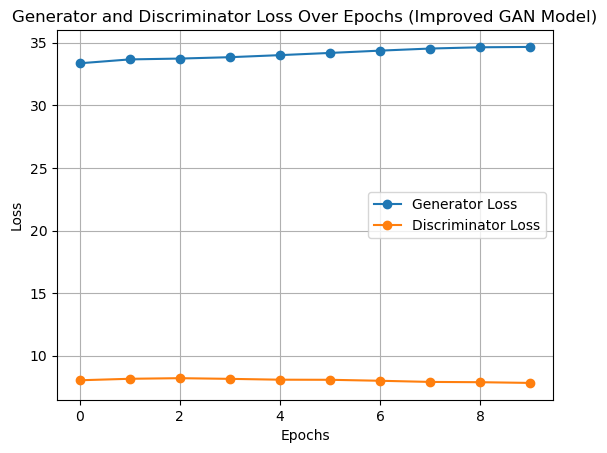

In [77]:
g_loss = sum(history.history['monet_gen_loss'], history.history['photo_gen_loss'])
d_loss = sum(history.history['monet_disc_loss'], history.history['photo_disc_loss'])

# Plotting the discriminator and generator loss metrics
epoch_list = range(10)
g_loss = g_loss.flatten()
g_loss = g_loss[:10]
d_loss = d_loss.flatten()
d_loss = d_loss[:10]

plt.plot(epoch_list, g_loss, label='Generator Loss', marker='o')
plt.plot(epoch_list, d_loss, label='Discriminator Loss', marker='o')

plt.title('Generator and Discriminator Loss Over Epochs (Improved GAN Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
import PIL
! mkdir ../images

mkdir: ../images: File exists


In [73]:
# Save the generated images into a local 'images' folder
i = 1
for img in photo_dataset:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [76]:
# Archive the generated images into a zip file
import shutil
shutil.make_archive("/images", 'zip', "/images")

## DISCUSSION, LESSONS LEARNED, AND CONCLUSION

I faced many challenges in working through this mini-project, but the greatest challenges to overcome turned out to be the following factors: properly preprocessing the input data before applying it to the GAN model and optimizing the GAN model itself. The development process involved many changes and updates to both the generator and discriminator components. Initially, I was not getting the proper results (the output generated images were literally gray images with no additional features). This led me to make changes to how I was preprocessing the data, which improved the output and generated a more feasible result. As this point, the synthetic images still had a lot of noise and were more distinguishable from the reference images, so as a next step, I made further updates to the generator and discriminator components for my GAN model. Once I made updates to these components, this led to more satisfactory results.

In terms of lessons learned, I learned the importance of the generator and discriminator components for a given GAN model (including how they are structured). Depending on your use case and what you are trying to achieve with the GAN model, the structure of the generators and discriminators can be significant factor in overall performance. With more time, I would definitely go back and make further updates to the generator and discriminator in order see how I can optimize the model even further for this use case.